In [ ]:
# 1. Download MALLET 2.0.8
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

# 2. Unzip the file
!unzip -q mallet-2.0.8.zip

# 3. Set the environment variable
mallet_home = '/content/mallet-2.0.8'
mallet_path = f'{mallet_home}/bin/mallet'
os.environ['MALLET_HOME'] = mallet_home

# Gensim for Coherence Model calculation
!pip install gensim pandas matplotlib tqdm

--2025-10-21 01:19:56--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2025-10-21 01:19:57--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  7.35MB/s    in 2.1s    

2025-10-21 01:20:00 (7.35 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 21.4 MB/s eta 0:00:00
MALLET setup complete. Gensim is at its latest version.


In [ ]:
import pandas as pd
import os
import shutil
import numpy as np
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import subprocess
import tempfile
import logging
from sentence_transformers import SentenceTransformer
import umap
import re
import torch
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
df = pd.read_excel("sbert_kmeans.xlsx")

Mallet LDA

In [ ]:
#Defining functions to run MALLET LDA

# SETUP
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
mallet_home = os.environ.get('MALLET_HOME', '/content/mallet-2.0.8')
mallet_path = f'{mallet_home}/bin/mallet'

# HELPER FUNCTIONS
def run_mallet_lda(dictionary, corpus, texts, k, temp_dir):
    input_file = os.path.join(temp_dir, 'mallet_input.txt')
    output_topic_keys = os.path.join(temp_dir, 'mallet_keys.txt')
    output_doc_topics = os.path.join(temp_dir, 'mallet_topics.txt')

    # Prepare MALLET input (doc_id \t label \t words)
    with open(input_file, 'w', encoding='utf8') as fout:
        for docno, doc in enumerate(texts):
            fout.write(f"doc_{docno}\tmallet_label\t{doc}\n")

    # Import to MALLET format
    subprocess.run([
        mallet_path, "import-file",
        "--input", input_file,
        "--output", os.path.join(temp_dir, "topic.mallet"),
        "--keep-sequence",
        "--remove-stopwords"
    ], check=True, capture_output=True, text=True)

    # Train MALLET LDA
    subprocess.run([
        mallet_path, "train-topics",
        "--input", os.path.join(temp_dir, "topic.mallet"),
        "--num-topics", str(k),
        "--output-topic-keys", output_topic_keys,
        "--output-doc-topics", output_doc_topics,
        "--optimize-interval", "100",
        "--num-iterations", "1000",
        "--random-seed", "42",
    ], check=True, capture_output=True, text=True)

    # Read topic-word distribution
    topic_words = []
    with open(output_topic_keys, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                words = parts[2].split(' ')
                topic_words.append(words)

    return topic_words, output_doc_topics


def compute_coherence_values(dictionary, corpus, texts, k_range):
    """Compute coherence for various K using MALLET LDA."""
    coherence_scores = {}
    with tempfile.TemporaryDirectory() as temp_dir:
        for k in tqdm(k_range, desc="Coherence Grid Search (MALLET)"):
            topic_words, _ = run_mallet_lda(dictionary, corpus, texts, k, temp_dir)
            tokenized_texts = [text.split() for text in texts]
            coherence_model = CoherenceModel(
                topics=topic_words,
                texts=tokenized_texts,
                dictionary=dictionary,
                coherence='c_v'
            )
            coherence_scores[k] = coherence_model.get_coherence()
    return coherence_scores

def parse_mallet_assignments(output_doc_topics_file, df_subset):
    """
    Parse MALLET doc-topics file, including ALL topic probabilities.
    """
    topic_assignments = []

    with open(output_doc_topics_file, 'r', encoding='utf8') as f:
        # Use a single loop to process all lines, skipping only comments/headers
        for line in f:
            if line.startswith('#') or not line.strip():
                continue # Skip header/comments/empty lines

            parts = line.strip().split('\t')

            # Check for standard MALLET output with at least doc_id, label, and one prob
            if len(parts) < 3:
                continue

            doc_id = parts[0]
            try:
                # Extracts the sequence number to use as a positional index
                doc_seq = int(doc_id.split('_')[-1])
            except ValueError:
                continue

            # Probabilities start from the 3rd part (index 2)
            try:
                probs = np.array(list(map(float, parts[2:])))
            except ValueError:
                continue

            if len(probs) == 0:
                continue

            # Find the best topic and its probability
            best_topic = int(np.argmax(probs))
            max_prob = probs[best_topic]

            # Use the positional index (doc_seq) to get the original DataFrame index
            original_index = df_subset.index[doc_seq]

            # Capture all topic probabilities
            assignment_data = {
                'document_index': original_index,
                'lda_topic_id': best_topic,
                'max_topic_prob': max_prob
            }

            # Add all individual topic probabilities
            for topic_idx, prob in enumerate(probs):
                assignment_data[f'topic_prob_{topic_idx}'] = prob

            topic_assignments.append(assignment_data)

    assignments_df = pd.DataFrame(topic_assignments)
    assignments_df.set_index('document_index', inplace=True)
    return assignments_df


def run_lda_for_cluster(cluster_id, cluster_name, df_subset):
    """Run full MALLET LDA pipeline for one SBERT cluster."""
    print(f"\n--- Processing Cluster {cluster_id}: {cluster_name} ---")

    texts = df_subset['clean_sentence_lda'].tolist()
    if not texts:
        print("Skipping: no valid sentences.")
        return

    # Check for empty strings after split, filter them out before creating dictionary
    tokenized_texts = [list(filter(None, text.split())) for text in texts]

    # Filter out documents that become empty after tokenization
    valid_texts_indices = [i for i, tokens in enumerate(tokenized_texts) if tokens]
    if not valid_texts_indices:
        print("Skipping: All sentences became empty after tokenization.")
        return

    # Keep only the valid, non-empty texts and their original document indices
    tokenized_texts = [tokenized_texts[i] for i in valid_texts_indices]
    texts = [texts[i] for i in valid_texts_indices]
    df_subset = df_subset.iloc[valid_texts_indices]


    dictionary = Dictionary(tokenized_texts)
    # Ensure min doc count is not too high for small clusters
    no_below_threshold = min(5, len(df_subset) // 10)
    dictionary.filter_extremes(no_below=no_below_threshold, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

    print(f" Corpus: {len(corpus)} sentences, Vocabulary: {len(dictionary)} unique words")

    # Coherence Grid Search
    k_range = range(2, min(11, len(corpus) // 2))
    if len(k_range) < 2:
        print("Skipping LDA: Too few documents or small k_range.")
        optimal_k = 2
    else:
        coherence_results = compute_coherence_values(dictionary, corpus, texts, k_range)

        # Select optimal K
        valid_scores = {k: score for k, score in coherence_results.items() if np.isfinite(score)}
        if not valid_scores:
            optimal_k = k_range.start
            max_coherence = float('nan')
        else:
            optimal_k = max(valid_scores, key=valid_scores.get)
            max_coherence = valid_scores[optimal_k]

        # Plot coherence
        plt.figure(figsize=(8,5))
        plt.plot(list(coherence_results.keys()), list(coherence_results.values()), marker='o', color='#007ACC')
        if np.isfinite(max_coherence):
            plt.scatter(optimal_k, max_coherence, color='red', s=100, label=f'Max Coherence (K={optimal_k})')
        plt.title(f'Cluster {cluster_id}: {cluster_name}\n$C_v$ Coherence vs K')
        plt.xlabel('Number of Topics (K)')
        plt.ylabel('C_v Coherence Score')
        plt.grid(True, alpha=0.5)
        plt.legend()
        plt.savefig(f'coherence_mallet_cluster_{cluster_id}.png')
        plt.close()
        print(f" Optimal K={optimal_k}, Max Coherence={max_coherence:.4f}")

    # Final MALLET LDA
    with tempfile.TemporaryDirectory() as temp_dir:
        topic_words_list, output_doc_topics = run_mallet_lda(dictionary, corpus, texts, optimal_k, temp_dir)

        # Save topic-word matrix
        topic_df = pd.DataFrame([{
            'global_topic_id': cluster_id,
            'lda_topic_id': topic_id,
            'coherence_score': max_coherence,
            'topic_words': ', '.join(words)
        } for topic_id, words in enumerate(topic_words_list)])
        topic_df.to_csv(f'lda_topics_mallet_cluster_{cluster_id}.csv', index=False)

        # Parse assignments
        assignments_df = parse_mallet_assignments(output_doc_topics, df_subset)

        # Merge by index (the default for .join())
        df_subset_final = df_subset.join(assignments_df, how='left')
        output_filename_sentences = f"lda_assignments_mallet_cluster_{cluster_id}.csv"
        df_subset_final.to_csv(output_filename_sentences, index=True) # Changed index=False to True to preserve original index
        print(f"Saved Topic-Sentence Assignments to {output_filename_sentences}")


    print(f" Saved topic matrix and assignments for Cluster {cluster_id}")


In [ ]:
# Broad topic clusters
label_map = {
    1: "dry_hydrate", 2: "price_value", 3: "glowy_appearance",
    4: "smell_scent", 5: "acne_effect", 6: "packaging_size"
}

# Filter dataset to include only valid clusters and non-empty sentences
df_filtered = df[
    (df['global_topic_id'] >= 1) & (df['global_topic_id'] <= 6) &
    (df['clean_sentence_lda'].str.strip().astype(bool))
].copy()

# Perform LDA on each broad topic cluster
for c_id in sorted(df_filtered['global_topic_id'].unique()):
    c_name = label_map.get(c_id, f"Cluster {c_id}")
    subset = df_filtered[df_filtered['global_topic_id'] == c_id].copy()
    run_lda_for_cluster(c_id, c_name, subset)

print("All cluster LDAs complete. CSVs now include 'lda_topic_id' and 'topic_prob'.")



--- Processing Cluster 1: dry_hydrate ---
 Corpus: 6357 sentences, Vocabulary: 746 unique words


Coherence Grid Search (MALLET):   0%|          | 0/9 [00:00<?, ?it/s]

 Optimal K=6, Max Coherence=0.3041
Saved Topic-Sentence Assignments to lda_assignments_mallet_cluster_1.csv
 Saved topic matrix and assignments for Cluster 1

--- Processing Cluster 2: price_value ---
 Corpus: 1723 sentences, Vocabulary: 304 unique words


Coherence Grid Search (MALLET):   0%|          | 0/9 [00:00<?, ?it/s]

 Optimal K=10, Max Coherence=0.4965
Saved Topic-Sentence Assignments to lda_assignments_mallet_cluster_2.csv
 Saved topic matrix and assignments for Cluster 2

--- Processing Cluster 3: glowy_appearance ---
 Corpus: 4594 sentences, Vocabulary: 679 unique words


Coherence Grid Search (MALLET):   0%|          | 0/9 [00:00<?, ?it/s]

 Optimal K=3, Max Coherence=0.3238
Saved Topic-Sentence Assignments to lda_assignments_mallet_cluster_3.csv
 Saved topic matrix and assignments for Cluster 3

--- Processing Cluster 4: smell_scent ---
 Corpus: 2352 sentences, Vocabulary: 373 unique words


Coherence Grid Search (MALLET):   0%|          | 0/9 [00:00<?, ?it/s]

 Optimal K=8, Max Coherence=0.4571
Saved Topic-Sentence Assignments to lda_assignments_mallet_cluster_4.csv
 Saved topic matrix and assignments for Cluster 4

--- Processing Cluster 5: acne_effect ---
 Corpus: 24502 sentences, Vocabulary: 2368 unique words


Coherence Grid Search (MALLET):   0%|          | 0/9 [00:00<?, ?it/s]

 Optimal K=8, Max Coherence=0.3885
Saved Topic-Sentence Assignments to lda_assignments_mallet_cluster_5.csv
 Saved topic matrix and assignments for Cluster 5

--- Processing Cluster 6: packaging_size ---
 Corpus: 2037 sentences, Vocabulary: 424 unique words


Coherence Grid Search (MALLET):   0%|          | 0/9 [00:00<?, ?it/s]

 Optimal K=7, Max Coherence=0.4026
Saved Topic-Sentence Assignments to lda_assignments_mallet_cluster_6.csv
 Saved topic matrix and assignments for Cluster 6
All cluster LDAs complete. CSVs now include 'lda_topic_id' and 'topic_prob'.


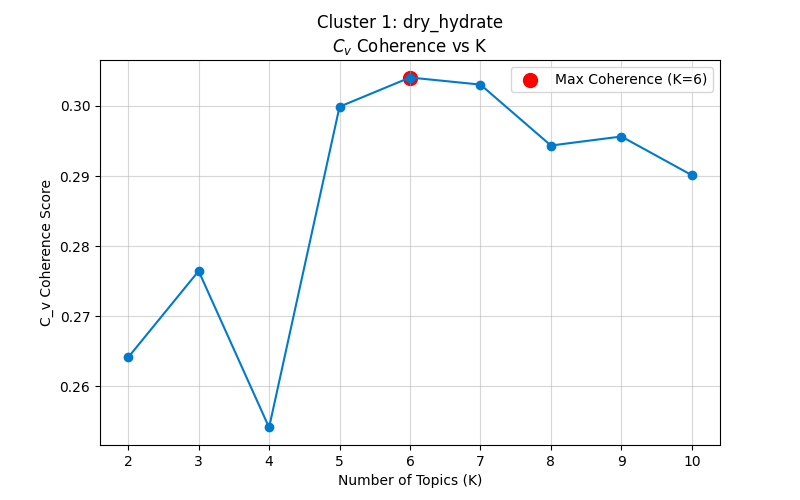

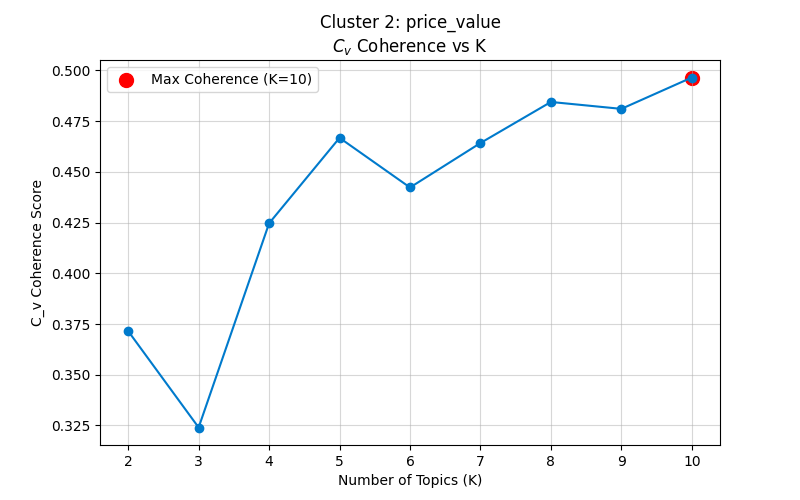

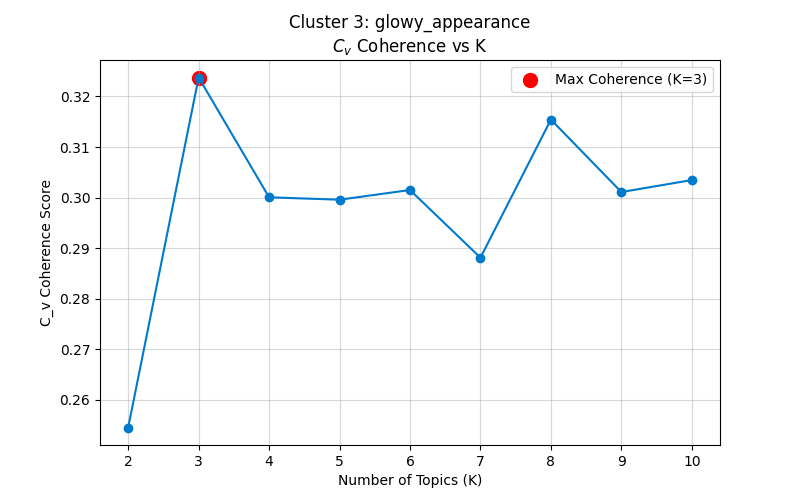

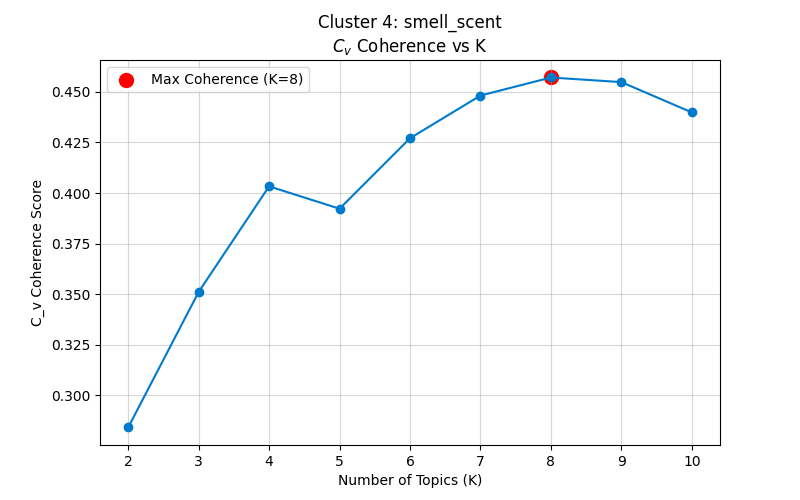

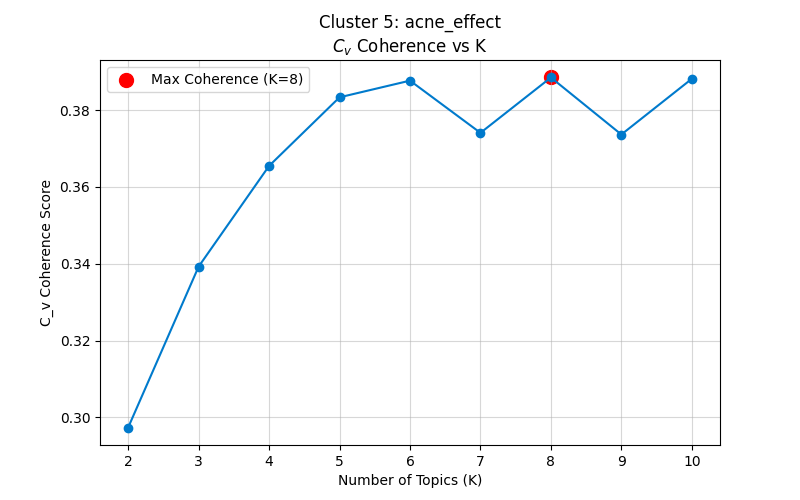

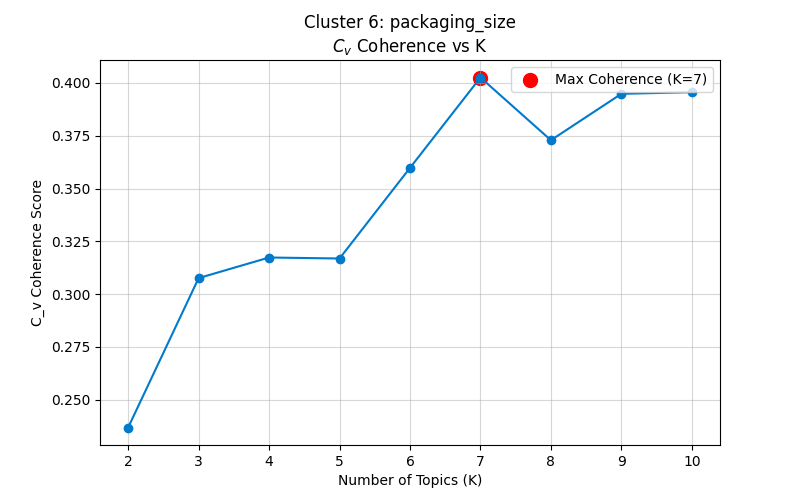

In [ ]:
# Coherence Score Plots
from IPython.display import display, Image
import os

plot_dir = "."
png_files = sorted([f for f in os.listdir(plot_dir) if f.endswith(".png")])

for file in png_files:
    display(Image(filename=os.path.join(plot_dir, file)))


UMAP Topic Visulisation

In [ ]:
# Settings
SBERT_MODEL = "BAAI/bge-large-en-v1.5"
UMAP_RANDOM_STATE = 42
TOPIC_COL = "lda_topic_id"
TEXT_COL = "sentence_text"
CLUSTER_IDS = [1, 2, 3, 4, 5, 6]
CLUSTER_PATH_TEMPLATE = "lda_assignments_mallet_cluster_{}.csv"
SAVE_DIR = "./umap_plots"
os.makedirs(SAVE_DIR, exist_ok=True)

# Helper Functions
def plot_umap_visual_validation(df, topic_col, save_path=None):
    plt.figure(figsize=(12, 10))
    cluster_id = df['global_topic_id'].iloc[0]

    topics = sorted(df[topic_col].unique())
    n_topics = len(topics)
    colors = plt.cm.get_cmap('tab10', n_topics)

    # 1. Compute centroids and coordinates
    centroid_coords = df.groupby(topic_col)[['umap_x','umap_y']].mean()

    # 2. Plot sentences
    for i, t in enumerate(topics):
        subset = df[df[topic_col] == t]
        plt.scatter(subset['umap_x'], subset['umap_y'],
                    s=15, alpha=0.5, label=f"Topic {t} ({len(subset)} docs)", color=colors(i))

    # 3. Highlight centroids (for visual reference)
    for i, t in enumerate(topics):
        x_c, y_c = centroid_coords.loc[t, 'umap_x'], centroid_coords.loc[t, 'umap_y']
        plt.scatter(x_c, y_c, marker='s', s=300, color=colors(i), edgecolor='black', zorder=5)
        plt.text(x_c, y_c, f"{t}", ha='center', va='center', fontsize=12, color='white', zorder=6)

    plt.title(f"UMAP Projection for Cluster {cluster_id}: LDA Subtopics (Validate Word Quality)", fontsize=16)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="LDA Topic ID (Documents)", loc='best')
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path, dpi=150)
        print(f"Saved UMAP plot to {save_path}")
    plt.close()
    return []

# Load SBERT model
print("Loading SBERT model...")
model = SentenceTransformer(SBERT_MODEL)
print("SBERT model loaded.")

# Loop over clusters
all_suggestions = {}
for cluster_id in CLUSTER_IDS:
    print(f"\n=== Processing Cluster {cluster_id} ===")

    # Load cluster CSV
    path = CLUSTER_PATH_TEMPLATE.format(cluster_id)
    try:
        df_cluster = pd.read_csv(path)
    except FileNotFoundError:
        print(f"File not found: {path}. Skipping.")
        continue

    # Ensure topic column is int
    df_cluster[TOPIC_COL] = df_cluster[TOPIC_COL].astype(int)

    # Filter empty sentences
    df_cluster = df_cluster[df_cluster[TEXT_COL].str.strip().astype(bool)].copy()
    if df_cluster.empty:
        print(f"Cluster {cluster_id} has no valid sentences, skipping.")
        continue

    # Compute SBERT embeddings
    print("Computing SBERT embeddings...")
    embeddings = model.encode(
        df_cluster[TEXT_COL].tolist(),
        batch_size=256,
        normalize_embeddings=True,
        show_progress_bar=True
    )

    df_cluster['sbert_embedding'] = list(embeddings)

    # UMAP projection
    print("Running UMAP...")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=UMAP_RANDOM_STATE)
    X_umap = reducer.fit_transform(embeddings)
    df_cluster['umap_x'] = X_umap[:, 0]
    df_cluster['umap_y'] = X_umap[:, 1]

    # Plot for VISUAL validation
    save_path = os.path.join(SAVE_DIR, f"umap_cluster_{cluster_id}.png")
    plot_umap_visual_validation(df_cluster, TOPIC_COL, save_path=save_path)

    print("UMAP plot generated.")

print("\n=== All clusters processed ===")

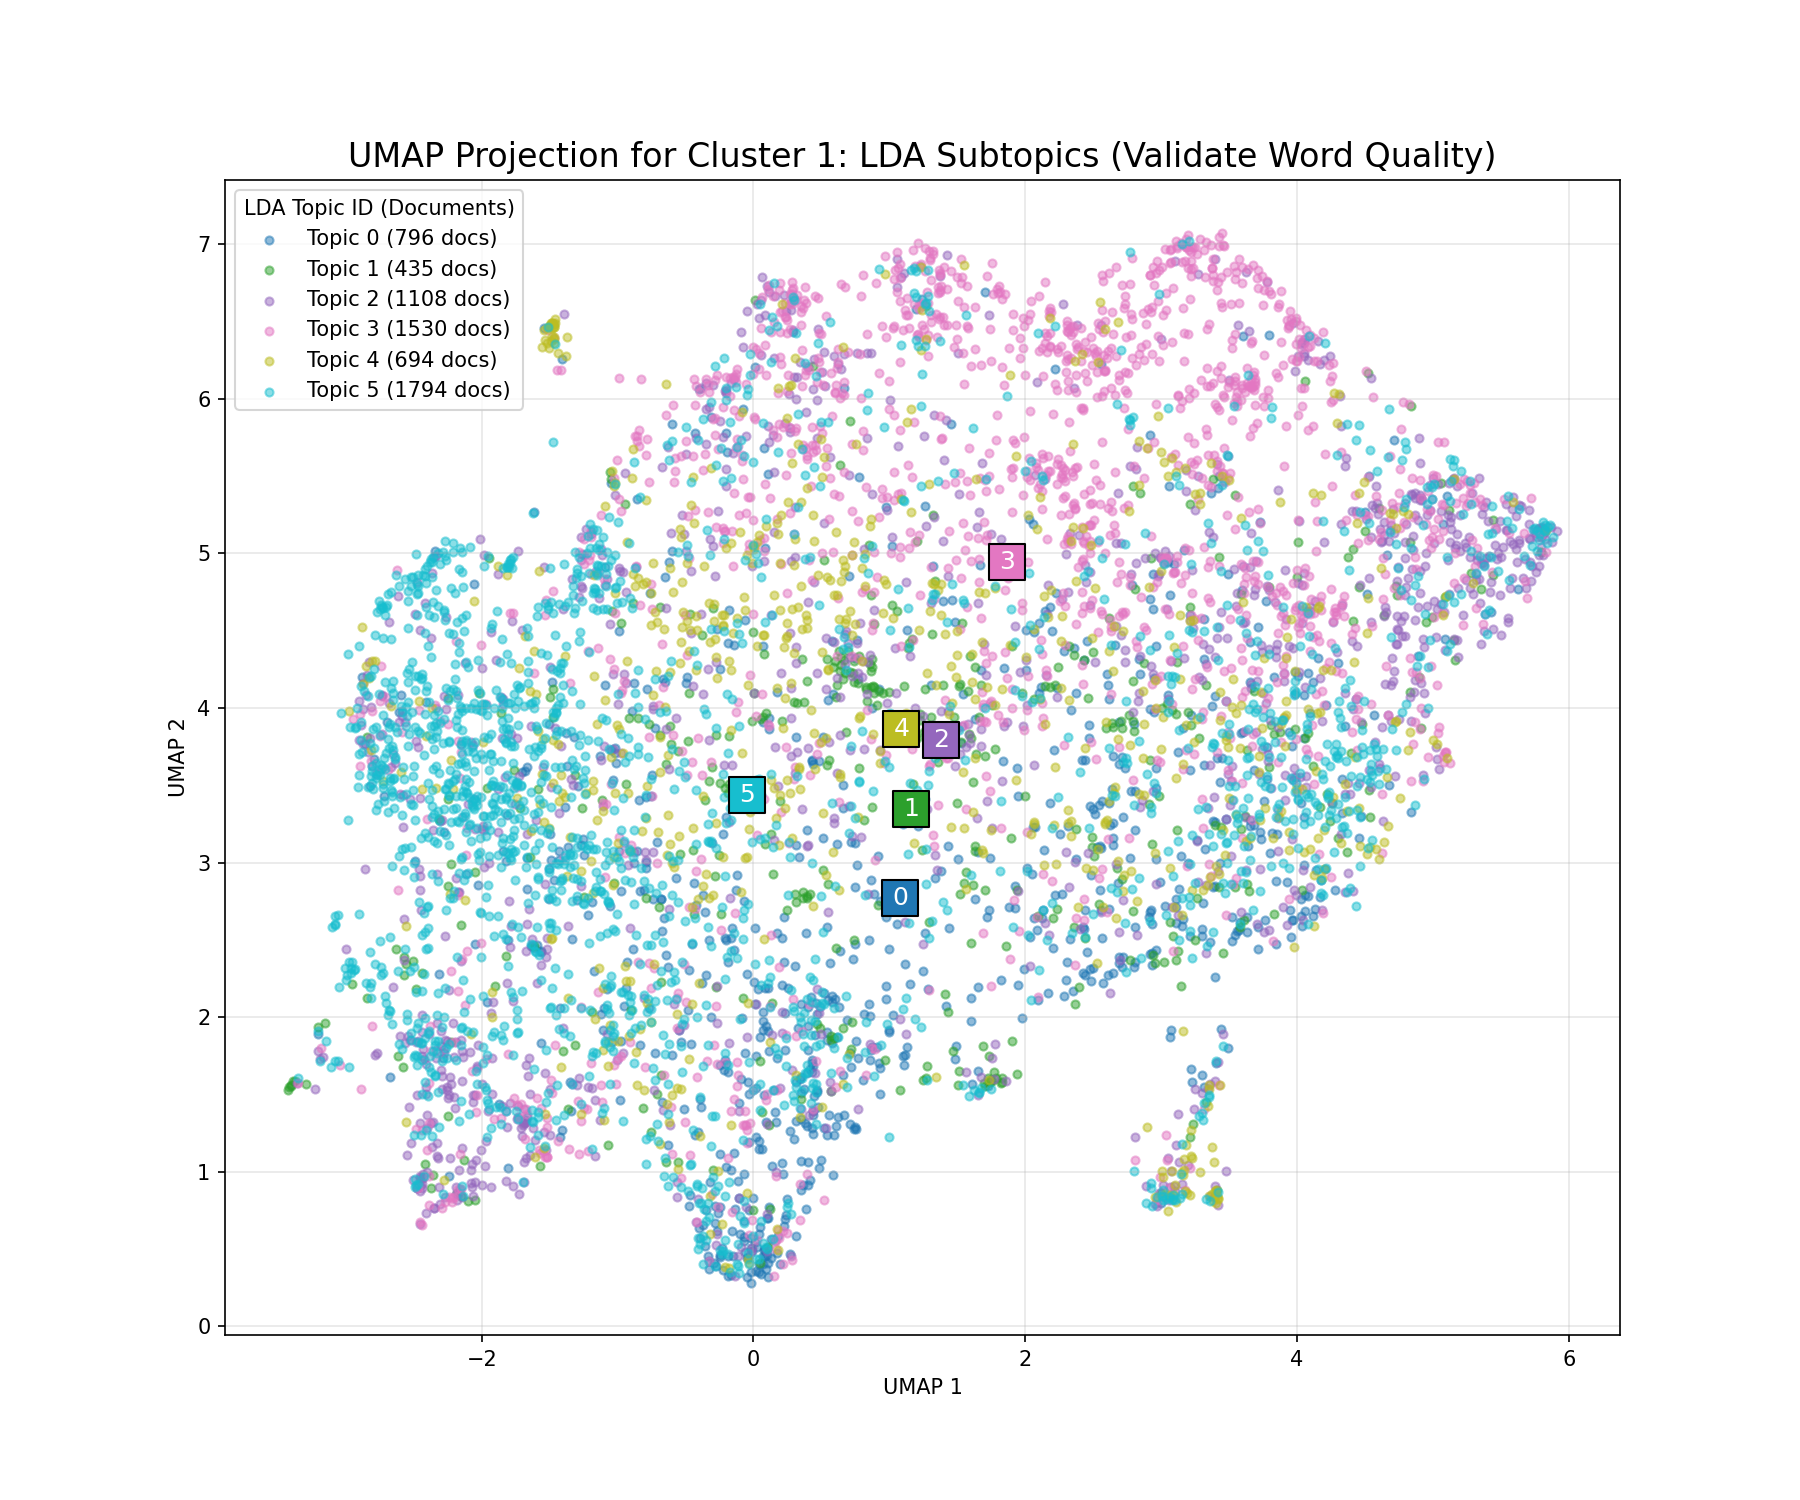

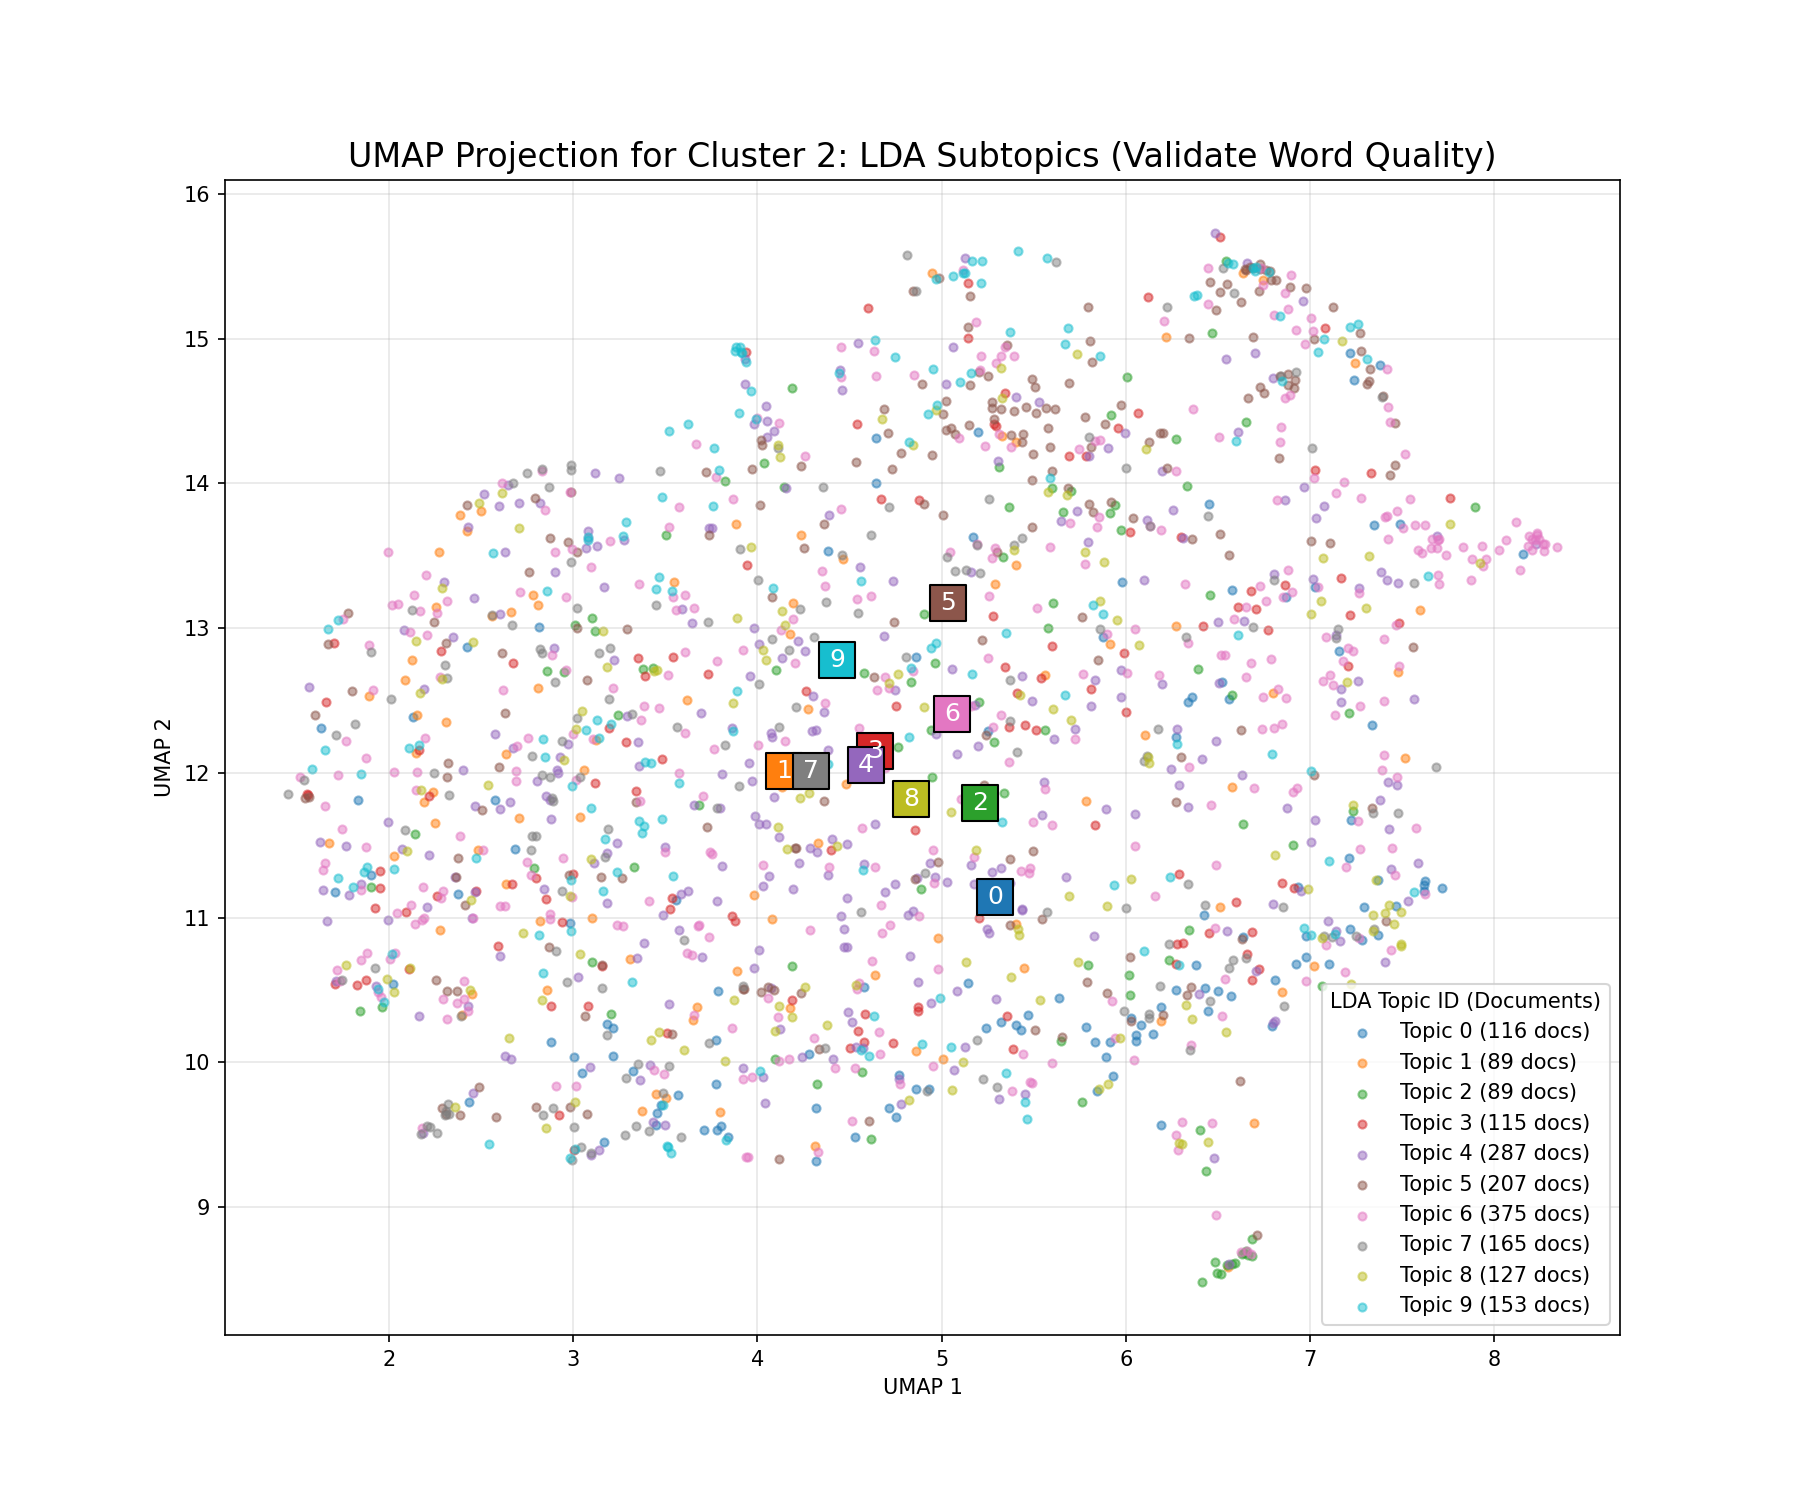

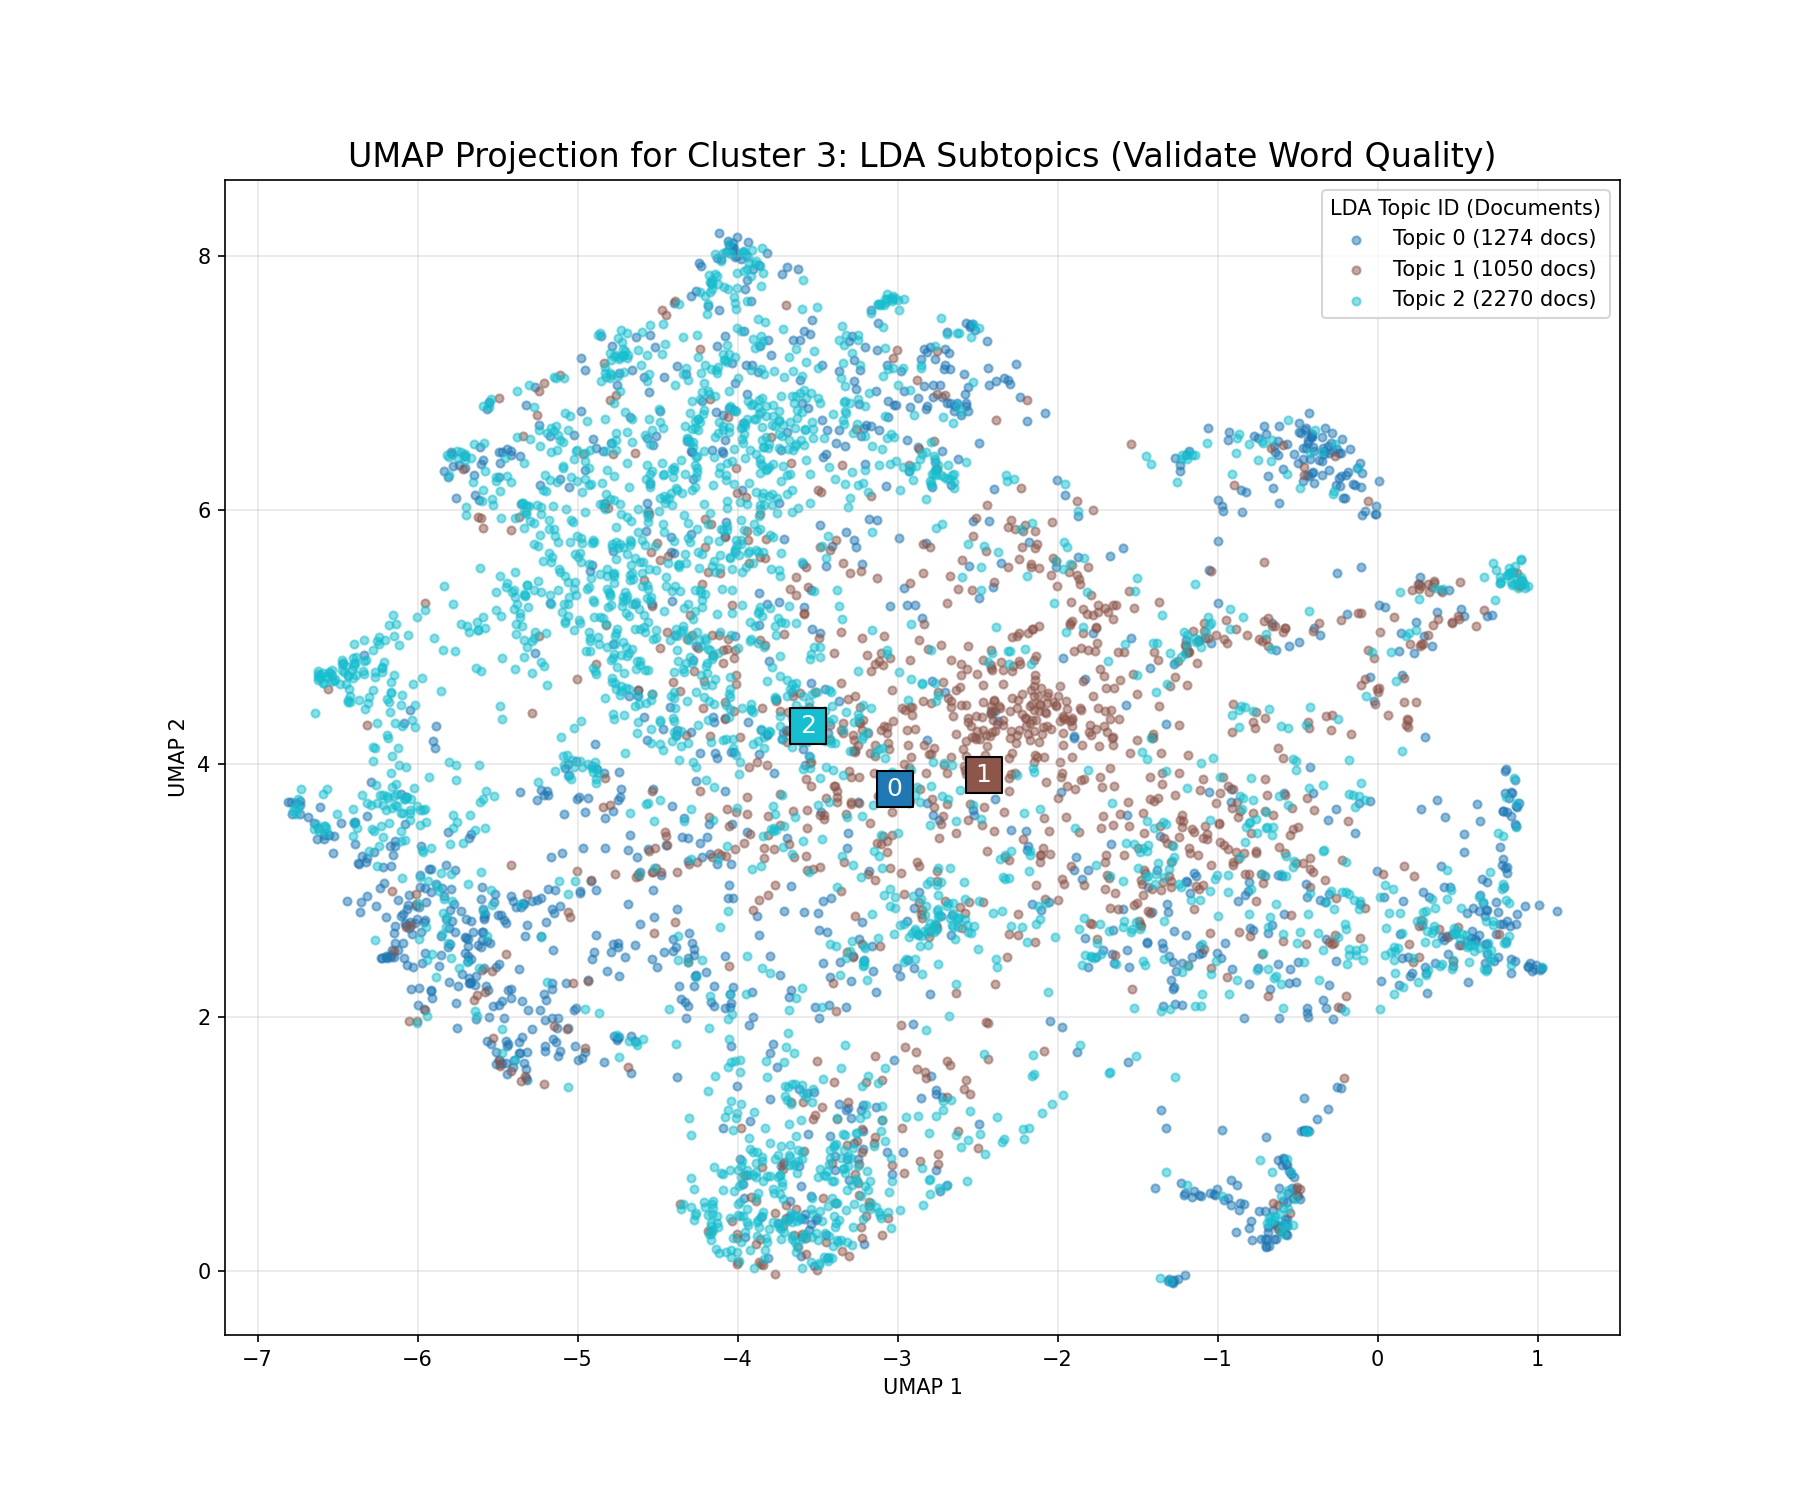

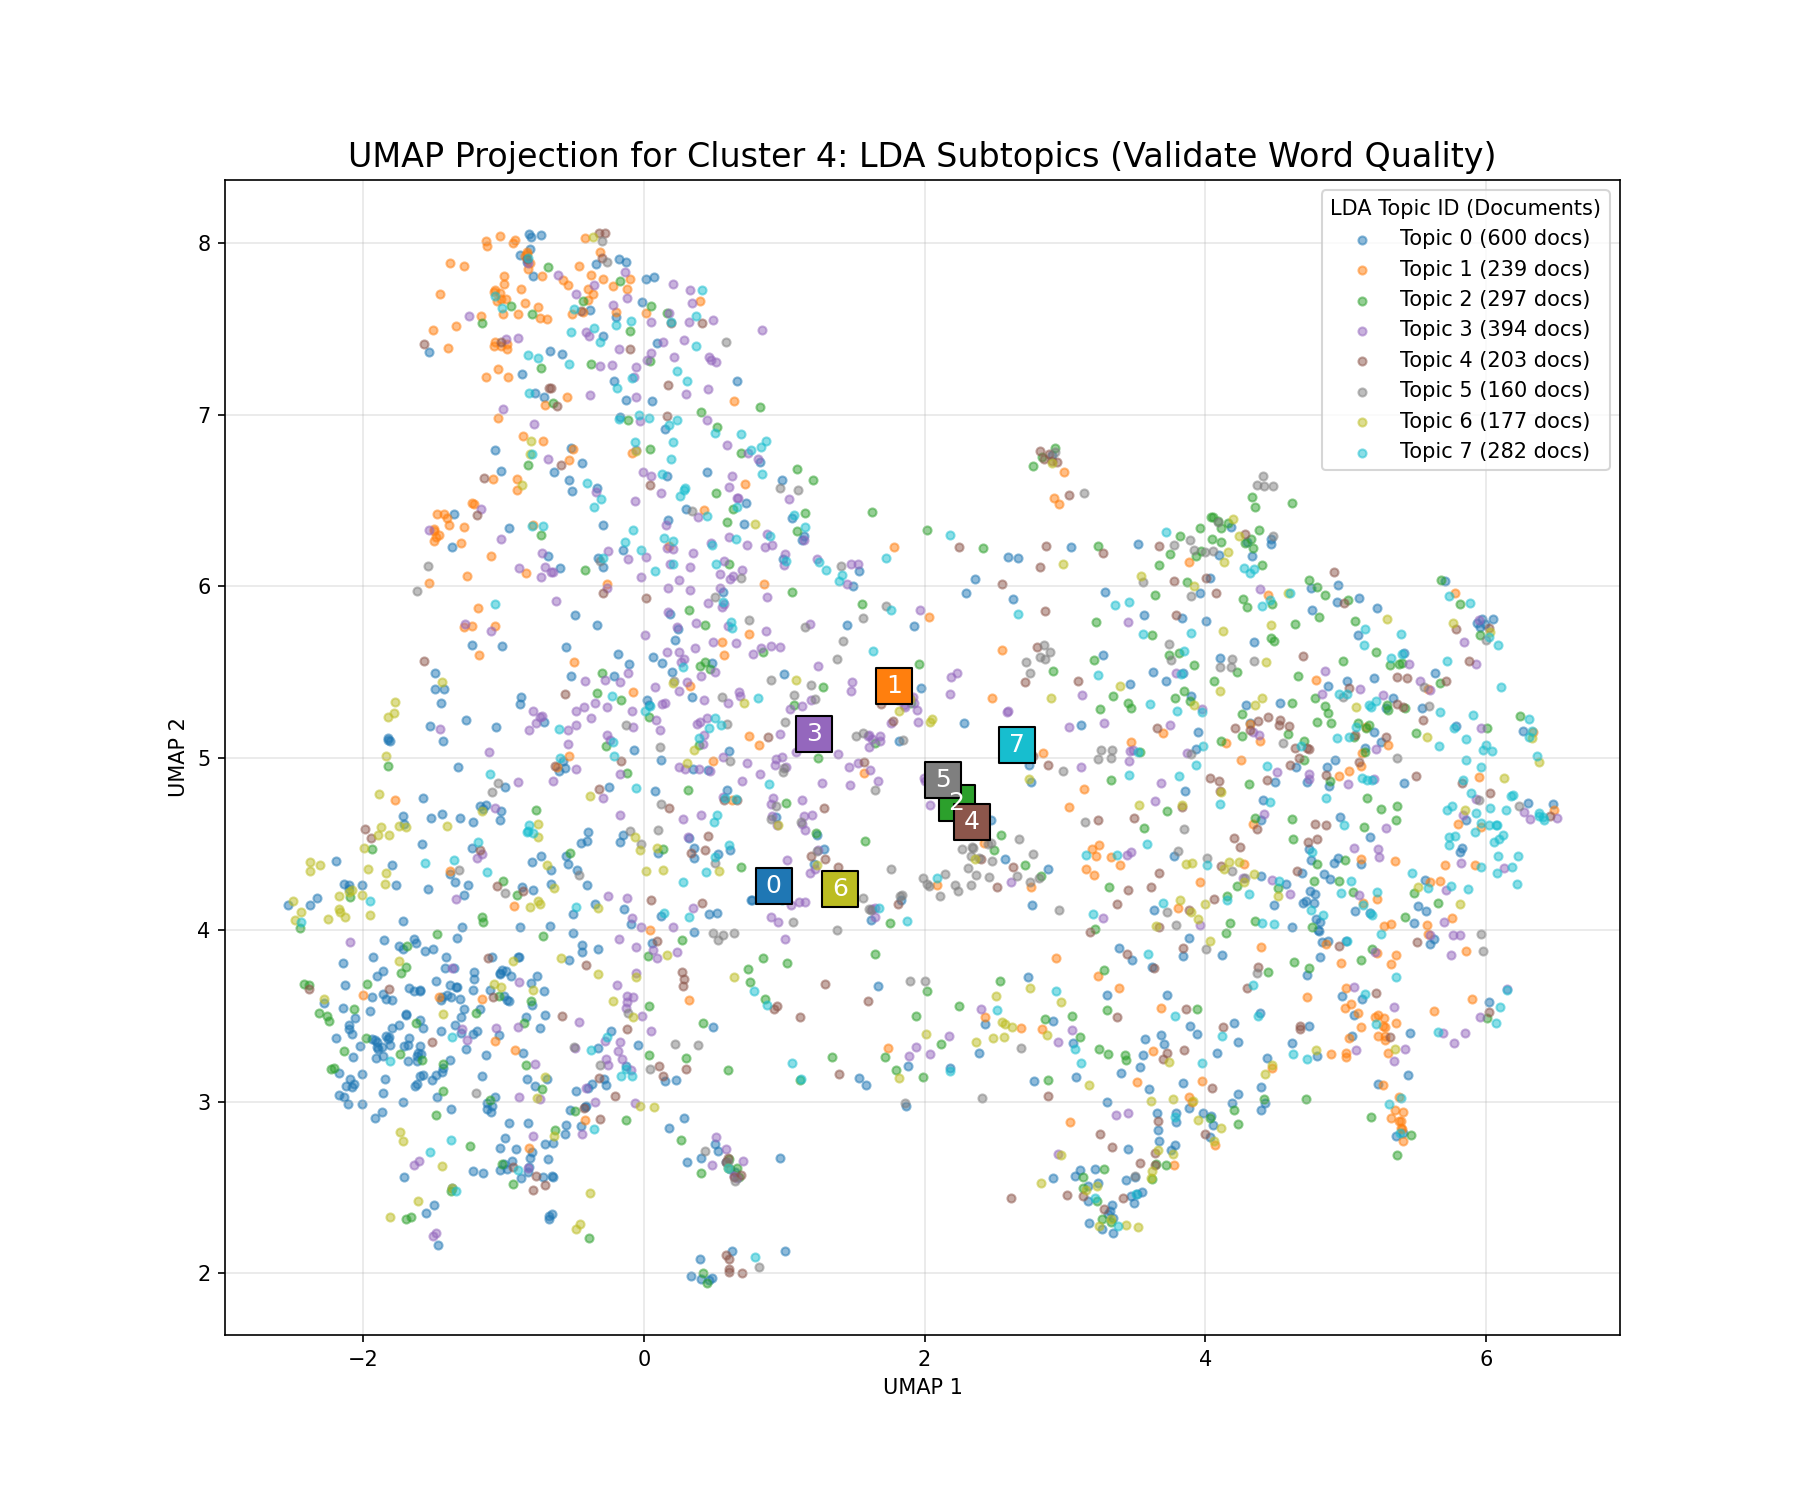

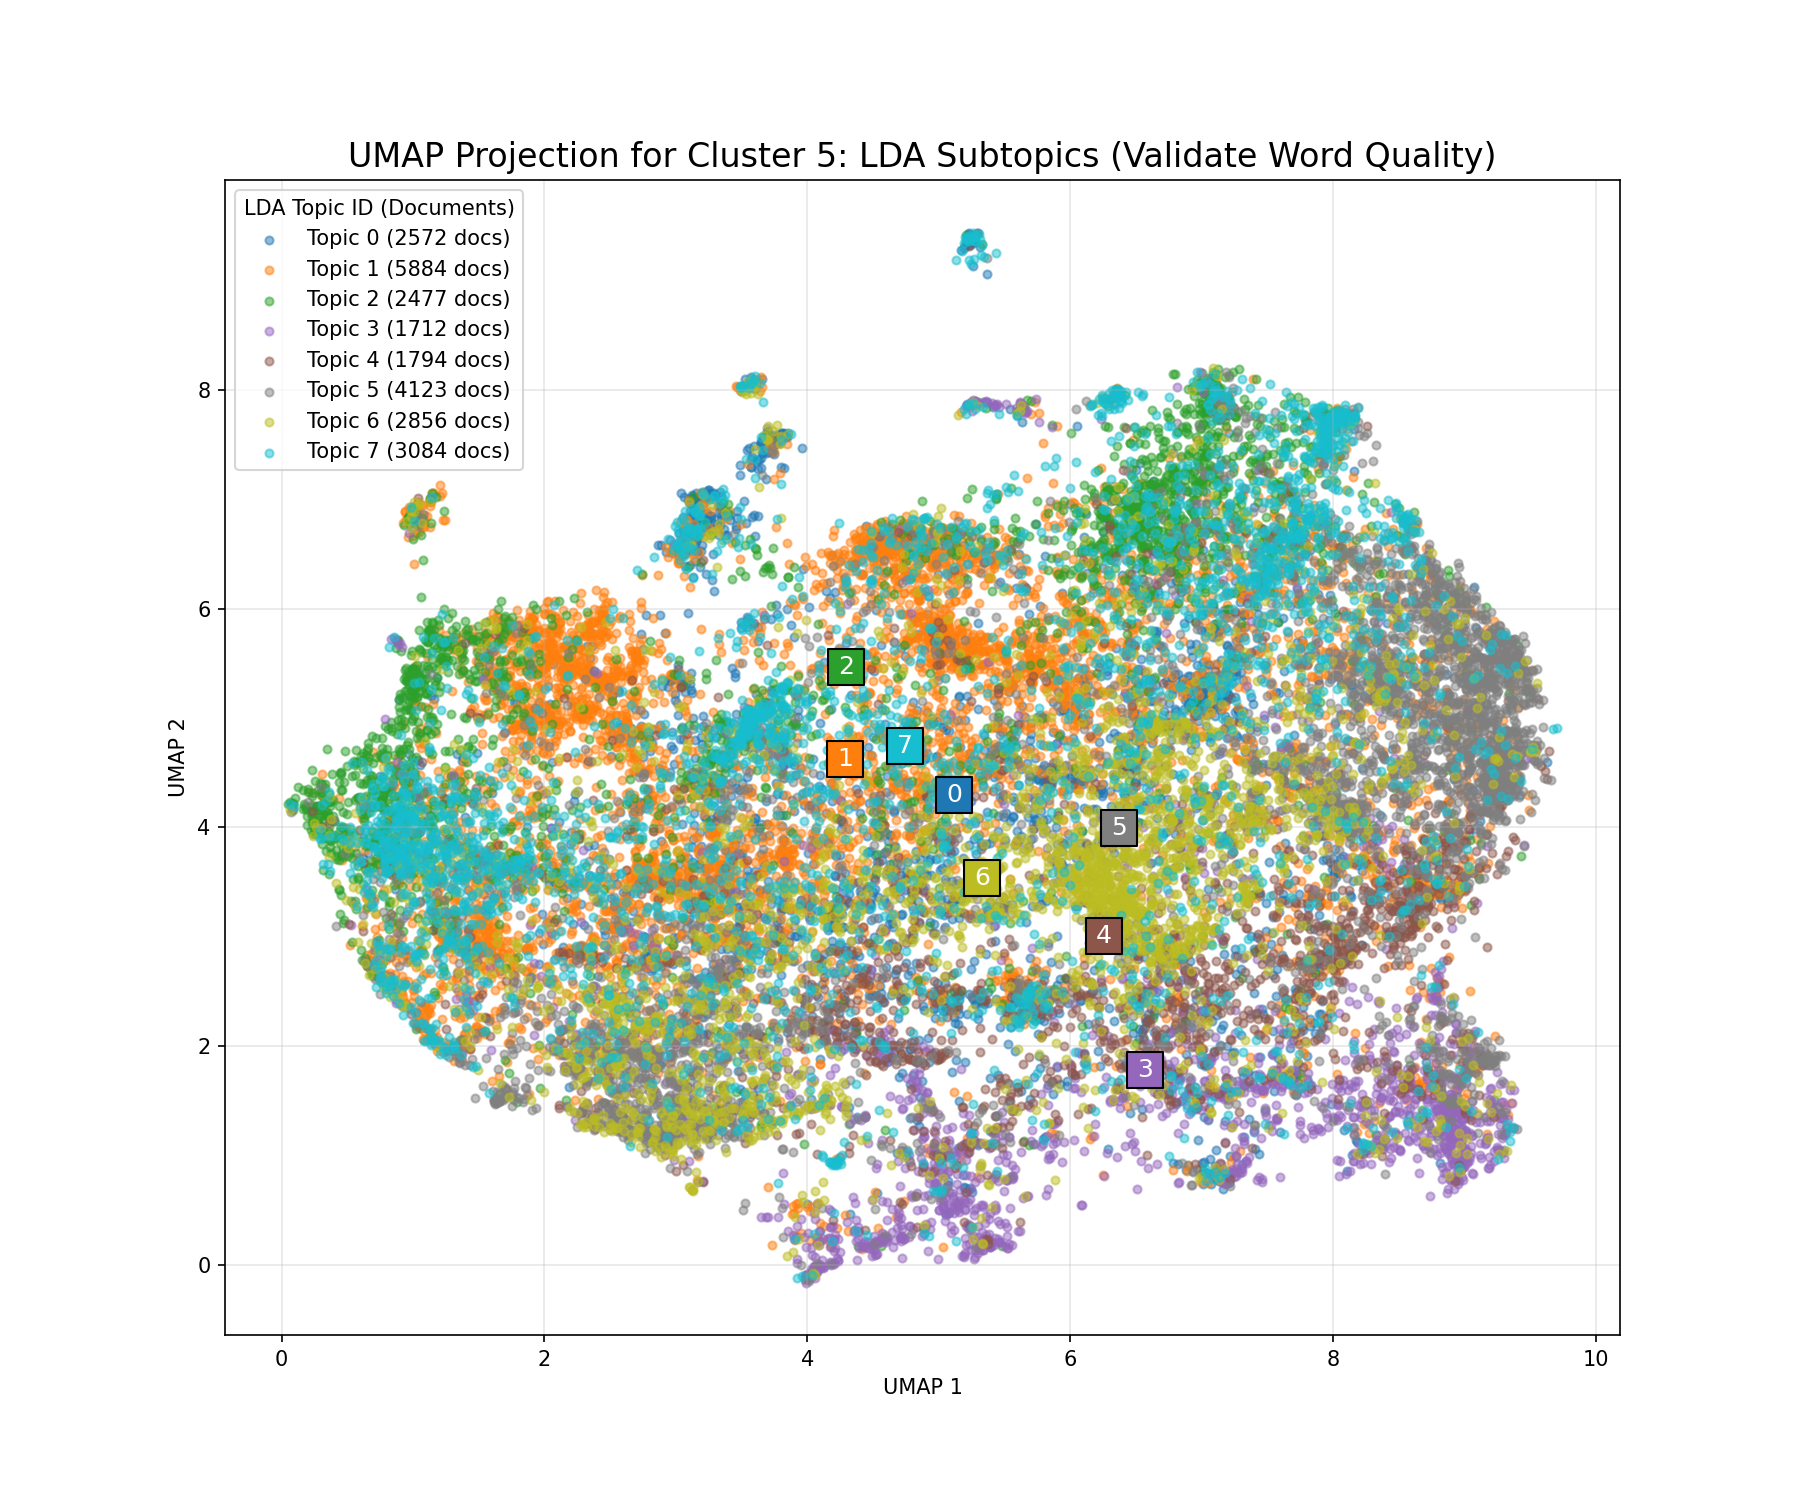

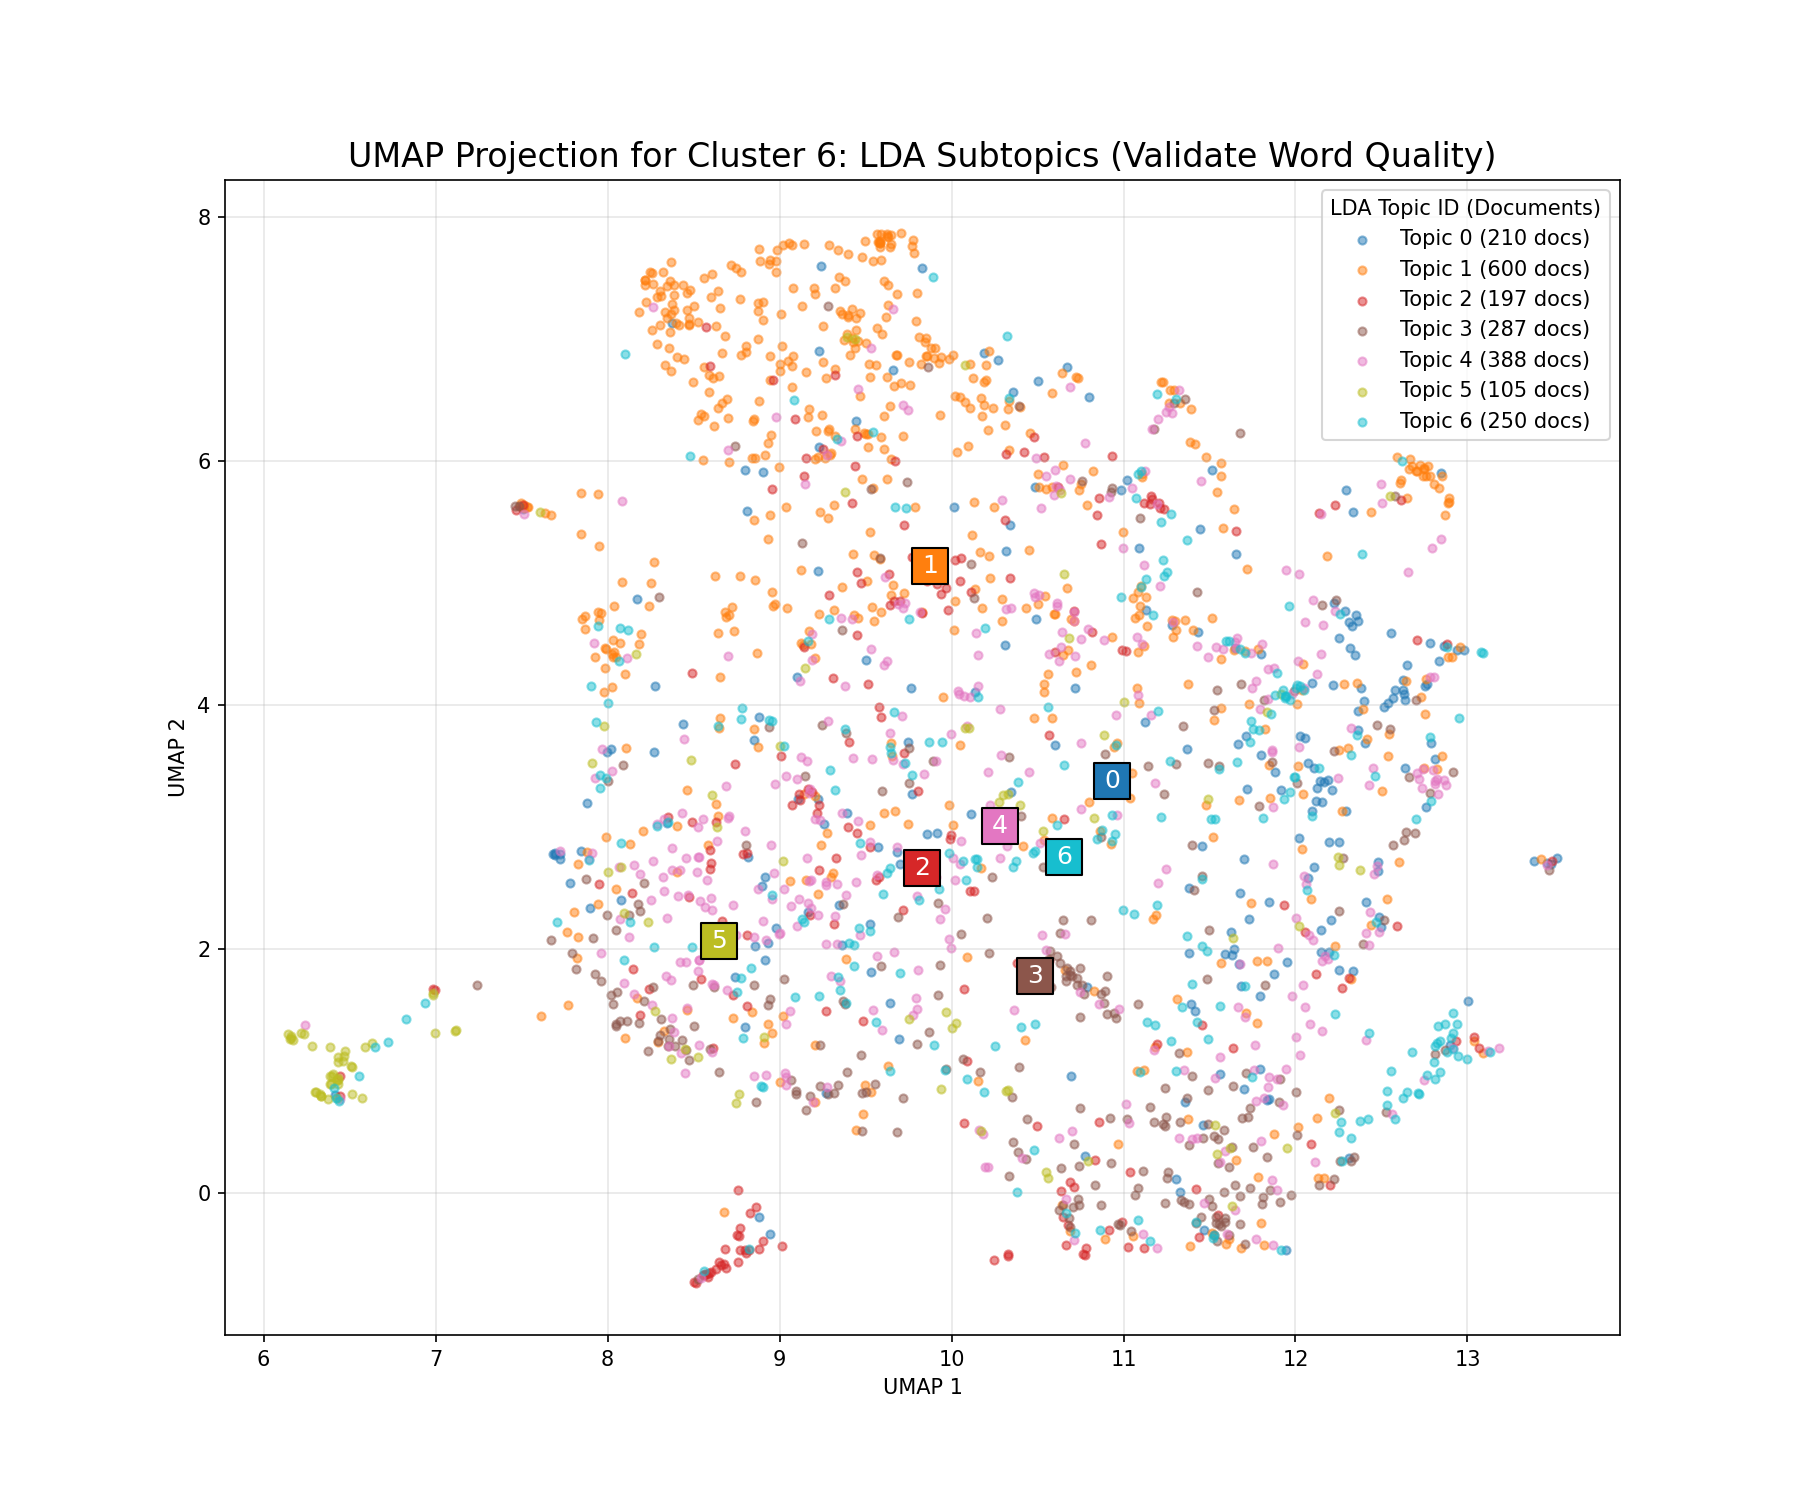

In [ ]:
from IPython.display import display, Image
import os

plot_dir = "./umap_plots"
png_files = sorted([f for f in os.listdir(plot_dir) if f.endswith(".png")])

for file in png_files:
    display(Image(filename=os.path.join(plot_dir, file)))


Merge & Finalise Subtopics

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# SETTINGS
SBERT_MODEL = "BAAI/bge-large-en-v1.5"
OUTPUT_FILE = "master_subtopic_cosine_similarity.csv"
BATCH_SIZE = 64
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_map = {
    1: "dry_hydrate", 2: "price_value", 3: "glowy_appearance",
    4: "smell_scent", 5: "acne_effect", 6: "packaging_size"
}

# Topic Reassignment
REASSIGNMENT_MAP = {
    1: {
        3: {'subtopic_id': 101, 'subtopic_name': 'Seasonal & Skin-Type Suitability'},
        'default': {'subtopic_id': 100, 'subtopic_name': 'Hydration & Texture'},
    },
    2: {
        'default': {'subtopic_id': 200, 'subtopic_name': 'Perceived Price–Value Tradeoff'},
    },
    3: {
        'default': {'subtopic_id': 300, 'subtopic_name': 'Glow & Skin Texture Effects'},
    },
    4: {
        1: {'subtopic_id': 400, 'subtopic_name': 'Safety & Sensitivity'},
        7: {'subtopic_id': 400, 'subtopic_name': 'Safety & Sensitivity'},
        3: {'subtopic_id': 401, 'subtopic_name': 'Pleasant Scent'},
        5: {'subtopic_id': 401, 'subtopic_name': 'Pleasant Scent'},
        2: {'subtopic_id': 402, 'subtopic_name': 'Strong/Unpleasant Scent'},
        4: {'subtopic_id': 402, 'subtopic_name': 'Strong/Unpleasant Scent'},
        0: {'subtopic_id': 403, 'subtopic_name': 'Product Feel & Application'},
        6: {'subtopic_id': 403, 'subtopic_name': 'Product Feel & Application'},
        'default': None
    },
    5: {
        0: {'subtopic_id': 500, 'subtopic_name': 'Product Routine & Type'},
        6: {'subtopic_id': 500, 'subtopic_name': 'Product Routine & Type'},
        1: {'subtopic_id': 501, 'subtopic_name': 'Skin Concerns & Acne'},
        2: {'subtopic_id': 501, 'subtopic_name': 'Skin Concerns & Acne'},
        7: {'subtopic_id': 501, 'subtopic_name': 'Skin Concerns & Acne'},
        3: {'subtopic_id': 502, 'subtopic_name': 'Eye & Makeup Removal'},
        4: {'subtopic_id': 503, 'subtopic_name': 'Cleansing & Exfoliation'},
        5: {'subtopic_id': 504, 'subtopic_name': 'Skin Feel & Texture'},
        'default': None
    },
    6: {
        1: {'subtopic_id': 600, 'subtopic_name': 'Size, Volume & Travel Value'},
        5: {'subtopic_id': 601, 'subtopic_name': 'Environmental Impact & Materials'},
        0: {'subtopic_id': 602, 'subtopic_name': 'Packaging Functionality & Dispensing'},
        2: {'subtopic_id': 602, 'subtopic_name': 'Packaging Functionality & Dispensing'},
        3: {'subtopic_id': 602, 'subtopic_name': 'Packaging Functionality & Dispensing'},
        4: {'subtopic_id': 602, 'subtopic_name': 'Packaging Functionality & Dispensing'},
        6: {'subtopic_id': 602, 'subtopic_name': 'Packaging Functionality & Dispensing'},
        'default': None
    }
}


# REASSIGNMENT & PROBABILITY FUNCTION
def reassign_subtopics_and_calculate_probs(df, global_topic_id):
    cluster_map = REASSIGNMENT_MAP.get(global_topic_id, {})
    df['final_subtopic_id'] = np.nan
    df['final_subtopic_name'] = None
    df['summed_subtopic_prob'] = np.nan

    subtopic_to_old_lda = {}
    for old_lda_id, mapping in cluster_map.items():
        if old_lda_id == 'default' or mapping is None:
            continue
        new_id = mapping['subtopic_id']
        subtopic_to_old_lda.setdefault(new_id, []).append(old_lda_id)

    # Assign mapped subtopics
    for old_lda_id, mapping in cluster_map.items():
        if old_lda_id == 'default' or mapping is None:
            continue
        mask = (df['lda_topic_id'] == old_lda_id)
        df.loc[mask, 'final_subtopic_id'] = mapping['subtopic_id']
        df.loc[mask, 'final_subtopic_name'] = mapping['subtopic_name']

    # Handle default group
    if 'default' in cluster_map and cluster_map['default'] is not None:
        default_id = cluster_map['default']['subtopic_id']
        mask_default = df['final_subtopic_id'].isna()
        df.loc[mask_default, 'final_subtopic_id'] = default_id
        df.loc[mask_default, 'final_subtopic_name'] = cluster_map['default']['subtopic_name']

    # Calculate subtopic probabilities
    prob_cols = [c for c in df.columns if re.match(r'topic_prob_\d+', c)]

    for new_id, old_ids in subtopic_to_old_lda.items():
        valid_cols = [f'topic_prob_{i}' for i in old_ids if f'topic_prob_{i}' in df.columns]
        if not valid_cols:
            continue
        df[f'subtopic_prob_{new_id}'] = df[valid_cols].sum(axis=1)
        mask = df['final_subtopic_id'] == new_id
        df.loc[mask, 'summed_subtopic_prob'] = df.loc[mask, f'subtopic_prob_{new_id}']

    # Default subtopic probability as residual
    if 'default' in cluster_map and cluster_map['default'] is not None:
        default_id = cluster_map['default']['subtopic_id']
        explicit_old_ids = [k for k in cluster_map.keys() if k != 'default']
        explicit_cols = [f'topic_prob_{i}' for i in explicit_old_ids if f'topic_prob_{i}' in df.columns]
        if explicit_cols:
            df[f'subtopic_prob_{default_id}'] = (1 - df[explicit_cols].sum(axis=1)).clip(lower=0)
            mask = df['final_subtopic_id'] == default_id
            df.loc[mask, 'summed_subtopic_prob'] = df.loc[mask, f'subtopic_prob_{default_id}']

    return df.dropna(subset=['final_subtopic_id']).copy()


# LOAD SBERT MODEL
print(f"Loading SBERT model: {SBERT_MODEL} on {device}...")
model = SentenceTransformer(SBERT_MODEL, device=device)
print("SBERT loaded successfully.\n")

# MAIN PROCESSING LOOP
all_dfs = []
for cluster_id in sorted(REASSIGNMENT_MAP.keys()):
    file_pattern = f'lda_assignments_mallet_cluster_{cluster_id}'
    found_files = [f for f in os.listdir() if f.startswith(file_pattern) and f.endswith('.csv')]
    if not found_files:
        print(f" File not found for cluster {cluster_id}. Skipping.")
        continue

    fname = found_files[0]
    print(f"Processing {fname} (Cluster {cluster_id}) ...")

    df = pd.read_csv(fname)
    df = df.dropna(subset=['sentence_text']).copy()
    df['lda_topic_id'] = pd.to_numeric(df['lda_topic_id'], errors='coerce').fillna(-1).astype(int)

    # Step 1: Reassign and compute probabilities
    df = reassign_subtopics_and_calculate_probs(df, cluster_id)
    if df.empty:
        print(f"Cluster {cluster_id} empty after reassignment, skipping.")
        continue

    # Step 2: Compute SBERT embeddings
    print(f"→ Computing embeddings for {len(df)} sentences ...")
    embeddings = model.encode(
        df['sentence_text'].tolist(),
        batch_size=BATCH_SIZE,
        show_progress_bar=True,
        normalize_embeddings=True
    )
    df['sbert_embedding'] = list(embeddings)
    df['global_topic_id'] = cluster_id
    all_dfs.append(df)

print("\nAll clusters processed successfully.")

# COMBINE ALL CLUSTERS
master_df = pd.concat(all_dfs, ignore_index=True)
master_df.rename(columns={'summed_subtopic_prob': 'max_subtopic_prob'}, inplace=True)

# Drop old topic prob columns
drop_cols = [c for c in master_df.columns if re.match(r'^topic_prob_\d+$', c)]
master_df.drop(columns=drop_cols, errors='ignore', inplace=True)

print(f"\nCombined total: {len(master_df)} sentences.\n")

# COMPUTE CENTROIDS AND COSINE SIMILARITY
print("Computing centroids and cosine similarity ...")
centroids = {
    sid: np.vstack(g['sbert_embedding']).mean(axis=0)
    for sid, g in master_df.groupby('final_subtopic_id')
}

def cosine_to_centroid(row):
    sid = row['final_subtopic_id']
    return cosine_similarity(
        row['sbert_embedding'].reshape(1, -1),
        centroids[sid].reshape(1, -1)
    )[0, 0]

master_df['cosine_to_centroid'] = master_df.apply(cosine_to_centroid, axis=1)

# Drop embeddings before saving
master_df.drop(columns=['sbert_embedding'], errors='ignore', inplace=True)

# SAVE OUTPUT
master_df.to_csv(OUTPUT_FILE, index=False)
print(f"\n Saved results to: {OUTPUT_FILE}")


Loading SBERT model: BAAI/bge-large-en-v1.5 on cpu...
SBERT loaded successfully.

Processing lda_assignments_mallet_cluster_1.csv (Cluster 1) ...
→ Computing embeddings for 6357 sentences ...


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Processing lda_assignments_mallet_cluster_2.csv (Cluster 2) ...
→ Computing embeddings for 1723 sentences ...


Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Processing lda_assignments_mallet_cluster_3.csv (Cluster 3) ...
→ Computing embeddings for 4594 sentences ...


Batches:   0%|          | 0/72 [00:00<?, ?it/s]

Processing lda_assignments_mallet_cluster_4.csv (Cluster 4) ...
→ Computing embeddings for 2352 sentences ...


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

Processing lda_assignments_mallet_cluster_5.csv (Cluster 5) ...
→ Computing embeddings for 24502 sentences ...


Batches:   0%|          | 0/383 [00:00<?, ?it/s]

Processing lda_assignments_mallet_cluster_6.csv (Cluster 6) ...
→ Computing embeddings for 2037 sentences ...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]


All clusters processed successfully.

Combined total: 41565 sentences.

Computing centroids and cosine similarity ...

 Saved results to: master_subtopic_cosine_similarity.csv


In [ ]:
# Exemplar Sentences based on Cosine Similarity to Topic Centroid
EXEMPLAR_COUNT = 5
EXEMPLAR_OUTPUT_FILE = "subtopic_exemplar_sentences_SBERT_RANKED.csv"

print(f"\nExtracting top {EXEMPLAR_COUNT} exemplars by SBERT Cosine Similarity...")

master_df['sbert_rank'] = master_df.groupby('final_subtopic_id')['cosine_to_centroid'] \
    .rank(method='first', ascending=False)

exemplars_df = master_df[master_df['sbert_rank'] <= EXEMPLAR_COUNT].copy()

exemplars_df = exemplars_df[[
    'final_subtopic_id',
    'final_subtopic_name',
    'global_topic_id',
    'sentence_text',
    'max_subtopic_prob',
    'cosine_to_centroid',
    'sbert_rank'
]]

exemplars_df.sort_values(by=['final_subtopic_id', 'sbert_rank'], inplace=True)
exemplars_df.to_csv(EXEMPLAR_OUTPUT_FILE, index=False)

print(f"Exemplar sentences (Top {EXEMPLAR_COUNT} per subtopic) saved to: {EXEMPLAR_OUTPUT_FILE}")

print("\n--- Final SBERT Ranked Exemplar Preview (Top 5) ---")
for sid, g in exemplars_df.groupby('final_subtopic_id'):
    subtopic_name = g['final_subtopic_name'].iloc[0]
    print(f"\nSubtopic {sid}: {subtopic_name}")

    top_rows = g.sort_values('sbert_rank').head(5)
    for i, row in top_rows.iterrows():
        print(f"[{row['sbert_rank']:.0f}] (CS: {row['cosine_to_centroid']:.3f}) {row['sentence_text']}")



Extracting top 5 exemplars by SBERT Cosine Similarity...
Exemplar sentences (Top 5 per subtopic) saved to: subtopic_exemplar_sentences_SBERT_RANKED.csv

--- Final SBERT Ranked Exemplar Preview (Top 5) ---

Subtopic 100.0: Hydration & Texture
[1] (CS: 0.907) After using, my skin does feel hydrated and soft.
[2] (CS: 0.905) After using this, my skin feels soft and hydrated.
[3] (CS: 0.905) After using this, my skin feels soft and hydrated.
[4] (CS: 0.905) My skin feels hydrated and soothed after using.
[5] (CS: 0.904) It makes my skin feel hydrated and soft.

Subtopic 101.0: Seasonal & Skin-Type Suitability
[1] (CS: 0.895) I have dry skin and was drawn to this product for hydration purposes.
[2] (CS: 0.894) I think this product is for those with dry skin.
[3] (CS: 0.893) I have combination skin a little towards dry.
[4] (CS: 0.890) My skin is on the dry side.
[5] (CS: 0.888) I have very dry skin and this product helps with hydration.

Subtopic 200.0: Perceived Price–Value Tradeoff
[1] (

In [ ]:
# Exemplar Sentences based on Topic Probability
EXEMPLAR_COUNT = 5
EXEMPLAR_OUTPUT_FILE = "subtopic_exemplar_sentences_BY_PROB.csv"

print(f"\nExtracting top {EXEMPLAR_COUNT} exemplars by subtopic probability...")

# Rank sentences within each subtopic group by the subtopic probability
master_df['prob_rank'] = master_df.groupby('final_subtopic_id')['max_subtopic_prob'] \
    .rank(method='first', ascending=False)

# Filter for only the top N exemplars
exemplars_df = master_df[master_df['prob_rank'] <= EXEMPLAR_COUNT].copy()

# Select and rename columns for a clean output
exemplars_df = exemplars_df[[
    'final_subtopic_id',
    'final_subtopic_name',
    'global_topic_id',
    'sentence_text',
    'max_subtopic_prob',
    'prob_rank'
]]

# Sort for easy review
exemplars_df.sort_values(by=['final_subtopic_id', 'prob_rank'], inplace=True)

# Save to CSV
exemplars_df.to_csv(EXEMPLAR_OUTPUT_FILE, index=False)
print(f"Exemplar sentences (Top {EXEMPLAR_COUNT} per subtopic) saved to: {EXEMPLAR_OUTPUT_FILE}")

# Preview top 5 per subtopic
print("\n--- Final Exemplar Preview by Subtopic Probability (Top 5) ---")
for sid, g in exemplars_df.groupby('final_subtopic_id'):
    subtopic_name = g['final_subtopic_name'].iloc[0]
    print(f"\nSubtopic {sid}: {subtopic_name}")

    top_rows = g.sort_values('prob_rank').head(5)
    for i, row in top_rows.iterrows():
        print(f"[{row['prob_rank']:.0f}] (Prob: {row['max_subtopic_prob']:.3f}) {row['sentence_text']}")



Extracting top 5 exemplars by subtopic probability...
Exemplar sentences (Top 5 per subtopic) saved to: subtopic_exemplar_sentences_BY_PROB.csv

--- Final Exemplar Preview by Subtopic Probability (Top 5) ---

Subtopic 100.0: Hydration & Texture
[1] (Prob: 0.984) This is perfect as my first step because it does an incredible job at cleaning all my makeup.PROS:It made an amazing job at cleaning all my makeup, including my waterproof mascara.It didn’t dry out my skin.A little goes a long way: I just need a little amount to remove my makeup.It has skin loving ingredients.Fragrance free.Great price for the amount you get and the quality of the product.Clean+planet positive.Cruelty freeCONS:It left a waxy feeling on my skin, but I don’t care because I use a second cleanser in my routine.I am sharing my honest and authentic opinion as a Sephora Beauty Insider Community Ambassador
[2] (Prob: 0.972) This moisturizer has all three recommended ingredients that make up a good moisturizer (humecta

In [ ]:
import pandas as pd
INPUT_FILE = "master_subtopic_cosine_similarity.csv"
OUTPUT_FILE = "master_subtopic_cosine_similarity_CLEANED.csv"

df = pd.read_csv(INPUT_FILE)
# Drop columns if they exist
cols_to_drop = ['lda_topic_id', 'max_topic_prob']
existing_cols_to_drop = [c for c in cols_to_drop if c in df.columns]

if existing_cols_to_drop:
    df.drop(columns=existing_cols_to_drop, inplace=True)
    print(f"Removed columns: {existing_cols_to_drop}")
else:
    print("No old columns found to remove.")

# Save cleaned file
df.to_csv(OUTPUT_FILE, index=False)
print(f"✅ Cleaned file saved as: {OUTPUT_FILE}")
print(f"Final shape: {df.shape}")


/tmp/ipython-input-2051965106.py:5: DtypeWarning: Columns (2,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_FILE)


Removed columns: ['lda_topic_id', 'max_topic_prob']
✅ Cleaned file saved as: master_subtopic_cosine_similarity_CLEANED.csv
Final shape: (41565, 57)


Integrate Sentiment Results

In [ ]:
# Merging with Sentiment Results
MASTER_INPUT_FILE = "master_subtopic_cosine_similarity_CLEANED.csv"
SENTIMENT_FILE = 'sentence_level_sentiment.csv'
SENTIMENT_COL = 'sentiment_score'
FINAL_OUTPUT_FILE = "Topic_sentiment_sentence_level_table.csv"

MERGE_KEYS = ['review_seq_id', 'sentence_index']
master_df = pd.read_csv(MASTER_INPUT_FILE)
df_sentiment = pd.read_csv(SENTIMENT_FILE)

df_sentiment = df_sentiment[MERGE_KEYS + [SENTIMENT_COL]].copy()
for col in MERGE_KEYS:
    # Ensure key columns are present and clean in the master file
    if col not in master_df.columns:
        print(f"FATAL ERROR: Merge key '{col}' is missing from {MASTER_INPUT_FILE}.")
        exit()

    # Standardize column types to integer for accurate merging
    master_df[col] = pd.to_numeric(master_df[col], errors='coerce').fillna(-1).astype(int)
    df_sentiment[col] = pd.to_numeric(df_sentiment[col], errors='coerce').fillna(-1).astype(int)

master_df = pd.merge(
    master_df,
    df_sentiment,
    on=MERGE_KEYS,
    how='left'
)

nan_count = master_df[SENTIMENT_COL].isna().sum()
successful_merge_count = len(master_df) - nan_count

print(f"Merge complete.")
print(f"   Total rows in final file: {len(master_df)}")
print(f"   Sentences successfully mapped: {successful_merge_count}")
if nan_count > 0:
    print(f"   Note: {nan_count} sentences could not be matched and have NaN sentiment.")

master_df.to_csv(FINAL_OUTPUT_FILE, index=False)
print(f"\nFinal file saved to: {FINAL_OUTPUT_FILE}")

/tmp/ipython-input-687886964.py:8: DtypeWarning: Columns (2,31) have mixed types. Specify dtype option on import or set low_memory=False.
  master_df = pd.read_csv(MASTER_INPUT_FILE)
/tmp/ipython-input-687886964.py:9: DtypeWarning: Columns (1,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sentiment = pd.read_csv(SENTIMENT_FILE)


Merge complete.
   Total rows in final file: 41565
   Sentences successfully mapped: 41565

Final file saved to: Topic_sentiment_sentence_level_table.csv


In [ ]:
# Update max probability as 1 for cluster 2 and 3 instead of blank (no finegrained subtopics)
import pandas as pd
import numpy as np

INPUT_FILE = "Topic_sentiment_sentence_level_table.csv"
OUTPUT_FILE_MODIFIED = INPUT_FILE

UNSPLIT_CLUSTERS = [200, 300]
PROB_COL = 'max_subtopic_prob'
SUBTOPIC_ID_COL = 'final_subtopic_id'

# 1. Load the sentence-level data
df_sentence = pd.read_csv(INPUT_FILE)

# 2. Identify rows belonging to clusters 200 or 300
condition = df_sentence[SUBTOPIC_ID_COL].isin(UNSPLIT_CLUSTERS)

# 3. For these rows, set the max_subtopic_prob to 1.0
df_sentence.loc[condition, PROB_COL] = 1.0

# 4. Save the modified DataFrame
df_sentence.to_csv(OUTPUT_FILE_MODIFIED, index=False)


Product-Level Topic Sentiment Summary Table

In [ ]:
# Get product overall average sentiment based on review-level sentiment scores
# FILE PATHS
REVIEW_LEVEL_FILE = "review_level_sentiment.csv"
SENTENCE_LEVEL_FILE = "sampled_400_sentence_level_no_dedup_latest.xlsx"
OUTPUT_FILE = "product_average_sentiment.csv"

# LOAD FILES
print("Loading review-level sentiment data...")
df_review = pd.read_csv(REVIEW_LEVEL_FILE)

print("Loading sentence-level mapping...")
df_sentences = pd.read_excel(SENTENCE_LEVEL_FILE, sheet_name="sentences")

# VALIDATE COLUMNS ---
required_cols_review = {"review_seq_id", "sentiment_score_w"}
required_cols_sentence = {"review_seq_id", "product_name_cleaned"}

if not required_cols_review.issubset(df_review.columns):
    raise ValueError(f"Missing columns in review file: {required_cols_review - set(df_review.columns)}")

if not required_cols_sentence.issubset(df_sentences.columns):
    raise ValueError(f"Missing columns in sentence file: {required_cols_sentence - set(df_sentences.columns)}")

# MERGE TO MAP PRODUCT NAMES
df_merged = pd.merge(df_review, df_sentences[["review_seq_id", "product_name_cleaned"]],
                     on="review_seq_id", how="left")

missing_products = df_merged["product_name_cleaned"].isna().sum()
print(f"Mapped {len(df_merged)} reviews. Missing product names for {missing_products} reviews.")

# COMPUTE PRODUCT-LEVEL AVERAGE SENTIMENT
product_sentiment = (
    df_merged
    .groupby("product_name_cleaned", dropna=True)
    .agg(
        ProductAvgSentiment=("sentiment_score_w", "mean"),
        ReviewCount=("review_seq_id", "nunique")
    )
    .reset_index()
)

# SAVE OUTPUT
product_sentiment.to_csv(OUTPUT_FILE, index=False)
print(f"\n✅ Product-level average sentiment saved to: {OUTPUT_FILE}")

print("\n--- Sample Product Sentiment Preview ---")
print(product_sentiment.head(10))


Loading review-level sentiment data...
Loading sentence-level mapping...
Mapped 69957 reviews. Missing product names for 0 reviews.

✅ Product-level average sentiment saved to: product_average_sentiment.csv

--- Sample Product Sentiment Preview ---
                                product_name_cleaned  ProductAvgSentiment  \
0                           A-Passioni Retinol Cream             0.434953   
1      AHA 30% + BHA 2% Exfoliating Peeling Solution             0.433582   
2                      Acne Solutions Cleansing Foam             0.422228   
3                 All About Clean Liquid Facial Soap             0.423029   
4          Alpha Beta Extra Strength Daily Peel Pads             0.435373   
5        Alpha Beta Pore Perfecting & Refining Serum             0.547355   
6               Alpha Beta Universal Daily Peel Pads             0.537972   
7              Aqua Bomb Brightening Vitamin C Cream             0.593587   
8                            Aqua Bomb Sleeping Mask      

In [14]:
# Product topic sentiment summary table

import re

df = pd.read_csv("Topic_sentiment_sentence_level_table.csv")

PRODUCT_AVG_FILE = "product_average_sentiment.csv" # Placeholder: Assuming this file is available or generated
OUTPUT_FILE_LONG = "Topic_sentiment_product_level_table_FINAL.csv"
SENTIMENT_COL = 'sentiment_score'
PROB_COL_PREFIX = 'subtopic_prob_'
PRODUCT_COL = 'product_name_cleaned'
PROB_MAX_COL = 'max_subtopic_prob' # The probability column for un-split clusters

# THEME & SUBTOPIC METADATA
SUBTOPIC_METADATA = {
    100: ['Hydration & Texture', 1, 'dry_hydrate'],
    101: ['Seasonal & Skin-Type Suitability', 1, 'dry_hydrate'],
    200: ['Perceived Price–Value Tradeoff', 2, 'price_value'],
    300: ['Glow & Skin Texture Effects', 3, 'glowy_appearance'],

    400: ['Safety & Sensitivity', 4, 'smell_scent'],
    401: ['Pleasant Scent', 4, 'smell_scent'],
    402: ['Strong/Unpleasant Scent', 4, 'smell_scent'],
    403: ['Product Feel & Application', 4, 'smell_scent'],

    500: ['Product Routine & Type', 5, 'acne_effect'],
    501: ['Skin Concerns & Acne', 5, 'acne_effect'],
    502: ['Eye & Makeup Removal', 5, 'acne_effect'],
    503: ['Cleansing & Exfoliation', 5, 'acne_effect'],
    504: ['Skin Feel & Texture', 5, 'acne_effect'],

    600: ['Size, Volume & Travel Value', 6, 'packaging_size'],
    601: ['Environmental Impact & Materials', 6, 'packaging_size'],
    602: ['Packaging Functionality & Dispensing', 6, 'packaging_size']
}


# Define the full list of ALL intended Subtopic IDs (including 200 and 300)
ALL_SUBTOPIC_IDS = sorted(SUBTOPIC_METADATA.keys())
UNSPLIT_CLUSTERS = [200, 300]
NUM_SUBTOPICS_EXPECTED = len(ALL_SUBTOPIC_IDS)


if PRODUCT_COL not in df.columns or SENTIMENT_COL not in df.columns:
    raise ValueError(f"Required columns '{PRODUCT_COL}' or '{SENTIMENT_COL}' not found in dataset.")
df[SENTIMENT_COL] = df[SENTIMENT_COL].fillna(0)
NUM_PRODUCTS = df['product_name_cleaned'].nunique()
EXPECTED_ROWS = NUM_PRODUCTS * NUM_SUBTOPICS_EXPECTED


# AGGREGATE TO PRODUCT–SUBTOPIC LEVEL
records = []

for product_name, df_prod in df.groupby(PRODUCT_COL):
    for subtopic_id in ALL_SUBTOPIC_IDS:

        # 1. DETERMINE PROBABILITY SOURCE
        if subtopic_id in UNSPLIT_CLUSTERS:
            # For un-split clusters (200, 300), use max_subtopic_prob, filtered by final_subtopic_id
            df_calc = df_prod[df_prod['final_subtopic_id'] == subtopic_id].copy()
            prob_col_name = PROB_MAX_COL # 'max_subtopic_prob'
        else:
            # For split subtopics, use the specific subtopic_prob_XXX column
            prob_col_name = f'{PROB_COL_PREFIX}{subtopic_id}'

            # Check if the column exists (important for split subtopics)
            if prob_col_name not in df_prod.columns:
                df_calc = pd.DataFrame() # Create empty dataframe to result in 0 scores
            else:
                df_calc = df_prod.copy()

        # 2. PERFORM CALCULATION
        if not df_calc.empty and prob_col_name in df_calc.columns:
            p_i_t = df_calc[prob_col_name].fillna(0)
            s_i = df_calc[SENTIMENT_COL]

            if p_i_t.sum() > 0:
                weighted_sentiment = p_i_t * s_i
                freq_weight = p_i_t.sum()
                subtopic_avg_sentiment = weighted_sentiment.sum() / freq_weight
                subtopic_score = subtopic_avg_sentiment * freq_weight
            else:
                freq_weight = 0
                subtopic_avg_sentiment = 0
                subtopic_score = 0
        else:
            freq_weight = 0
            subtopic_avg_sentiment = 0
            subtopic_score = 0

        # 3. RECORD METADATA
        meta = SUBTOPIC_METADATA.get(subtopic_id, ['UNKNOWN', np.nan, 'UNKNOWN'])
        subtopic_name, cluster_id, cluster_name = meta

        records.append({
            'product_name_cleaned': product_name,
            'Theme_id': cluster_id,
            'Theme_name': cluster_name,
            'subtopic_id': subtopic_id,
            'subtopic_name': subtopic_name,
            'FreqWeight (Topic Prominence)': freq_weight,
            'Subtopic_AvgSentiment': subtopic_avg_sentiment,
            'SubTopicScore': subtopic_score
        })

df_long = pd.DataFrame(records)


# MERGE PRODUCT-LEVEL AVERAGE SENTIMENT
try:
    df_prod_sentiment = pd.read_csv(PRODUCT_AVG_FILE)
    if 'ProductAvgSentiment' not in df_prod_sentiment.columns:
         raise ValueError(f"Expected 'ProductAvgSentiment' column in {PRODUCT_AVG_FILE}.")
except:
    print(f"Warning: {PRODUCT_AVG_FILE} not found or invalid. Calculating ProductAvgSentiment from sentence data.")
    df_prod_sentiment = df.groupby(PRODUCT_COL)[SENTIMENT_COL].mean().reset_index().rename(columns={SENTIMENT_COL: 'ProductAvgSentiment'})

df_long = df_long.merge(df_prod_sentiment[['product_name_cleaned', 'ProductAvgSentiment']],
                        on='product_name_cleaned', how='left')

# ADD RELATIVE SENTIMENT METRIC
df_long['RelativeSubtopicSentiment'] = df_long['Subtopic_AvgSentiment'] - df_long['ProductAvgSentiment']

# SAVE OUTPUT
df_long.to_csv(OUTPUT_FILE_LONG, index=False)


# --- FINAL VALIDATION CHECK ---
print(f"\n--- FINAL AGGREGATION VALIDATION ---")
print(f"Total Products found: {NUM_PRODUCTS}")
print(f"Total Subtopics expected: {NUM_SUBTOPICS_EXPECTED}")
print(f"Total rows expected: {EXPECTED_ROWS}")
print(f"Total rows created: {len(df_long)}")

if len(df_long) == EXPECTED_ROWS:
    print("✅ VALIDATION SUCCESS: The final table contains the expected number of product-subtopic rows.")
else:
    print(f"❌ VALIDATION FAILURE: Expected {EXPECTED_ROWS} rows but found {len(df_long)}.")

print("\n--- Check: Number of Products per Subtopic (All should equal 42) ---")
subtopic_counts = df_long.groupby('subtopic_id').size().to_frame(name='Product_Count')
print(subtopic_counts.sort_index().to_markdown())

print("\n--- Check: Number of Subtopics per Product (All should equal 16) ---")
product_subtopic_counts = df_long.groupby('product_name_cleaned').size().to_frame(name='Subtopic_Count')
print(product_subtopic_counts['Subtopic_Count'].value_counts().to_markdown())

/tmp/ipython-input-3363929245.py:5: DtypeWarning: Columns (2,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Topic_sentiment_sentence_level_table.csv")



--- FINAL AGGREGATION VALIDATION ---
Total Products found: 42
Total Subtopics expected: 16
Total rows expected: 672
Total rows created: 672
✅ VALIDATION SUCCESS: The final table contains the expected number of product-subtopic rows.

--- Check: Number of Products per Subtopic (All should equal 42) ---
|   subtopic_id |   Product_Count |
|--------------:|----------------:|
|           100 |              42 |
|           101 |              42 |
|           200 |              42 |
|           300 |              42 |
|           400 |              42 |
|           401 |              42 |
|           402 |              42 |
|           403 |              42 |
|           500 |              42 |
|           501 |              42 |
|           502 |              42 |
|           503 |              42 |
|           504 |              42 |
|           600 |              42 |
|           601 |              42 |
|           602 |              42 |

--- Check: Number of Subtopics per Product (All